In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install deap

     |████████████████████████████████| 163kB 2.7MB/s 


In [3]:
!pip install bitstring

     |████████████████████████████████| 204kB 2.5MB/s 
  Created wheel for bitstring: filename=bitstring-3.1.7-cp36-none-any.whl size=37948 sha256=7ff20b92d185984e41ad02aa5bfd505cdf21a1324b0e0ed4062cf4afd2acddb5
  Stored in directory: /root/.cache/pip/wheels/b8/27/f0/8373e26b7de57db03dc18aaaebdd8c26a99da882416f762979
Successfully built bitstring


In [4]:
!pip install transforms3d

     |████████████████████████████████| 71kB 2.1MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-cp36-none-any.whl size=59375 sha256=02af3ac99366356f0ed3a2e791825f92d712d3dfc629e3a796d5b10ac97e2aa8
  Stored in directory: /root/.cache/pip/wheels/3d/3c/84/28d36677f3c760c048bd02b5a547ea0c4027770cc9cdb9af1e
Successfully built transforms3d


In [5]:
!pip install tsaug

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [7]:
pwd

'/content'

In [8]:
%cd "/content/drive/My Drive/Colab Notebooks/covid-dataset/"

/content/drive/My Drive/Colab Notebooks/covid-dataset


In [9]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [10]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid-dataset/owid-covid-data.csv') # having First.csv zipped file.

In [11]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [12]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [13]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [14]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [15]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [16]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [17]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [18]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [19]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [20]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [21]:
df = df.fillna(df.median())

In [22]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [23]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [24]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [25]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [26]:
#df['month'] = df['date'].dt.month

In [27]:
nb_seq=7
n_out=7
nb_col=5

In [28]:
start_date = '2020-03-02'
end_date = '2020-05-24'
start_date2 = '2020-05-25'
end_date2 = '2020-06-14'

In [29]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [30]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [31]:
df.sort_values(by=['location'], inplace=True)


In [32]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(84, 7)

In [33]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [34]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23007,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
23008,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
23009,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
23010,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
23011,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [35]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [36]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [37]:
X_train.shape

(84, 7)

In [38]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22928,7.0,615.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22929,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22930,7.0,615.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22931,7.0,615.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22932,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22933,7.0,615.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22934,7.0,615.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22935,7.0,615.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22936,7.0,615.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22937,7.0,615.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [39]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23002,95.0,6607.0,190.0,2.0,36910558.0,2020-05-15,Morocco
23003,45.0,6652.0,190.0,0.0,36910558.0,2020-05-16,Morocco
23004,89.0,6741.0,192.0,2.0,36910558.0,2020-05-17,Morocco
23005,129.0,6870.0,192.0,0.0,36910558.0,2020-05-18,Morocco
23006,82.0,6952.0,192.0,0.0,36910558.0,2020-05-19,Morocco
23007,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
23008,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
23009,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
23010,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
23011,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [40]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(21, 7)

In [41]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [42]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,129.0,6870.0,192.0,0.0,36910558.0,2020-05-18,Morocco
1,82.0,6952.0,192.0,0.0,36910558.0,2020-05-19,Morocco
2,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
3,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
4,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
5,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
6,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco
7,27.0,7433.0,199.0,1.0,36910558.0,2020-05-25,Morocco
8,99.0,7532.0,200.0,1.0,36910558.0,2020-05-26,Morocco
9,45.0,7577.0,202.0,2.0,36910558.0,2020-05-27,Morocco


In [43]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [44]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [45]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [46]:
#days=days[nb_seq:]

In [47]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(84, 5)
(84, 1)
(28, 5)
(28, 1)


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [49]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-7)  var2(t-7)  var3(t-7)  ...  var3(t+6)  var4(t+6)  var5(t+6)
7    0.024911   0.082917   0.050505  ...   0.005051   0.000000        0.0
8    0.003559   0.000000   0.000000  ...   0.005051   0.000000        0.0
9    0.024911   0.082917   0.050505  ...   0.005051   0.000000        0.0
10   0.024911   0.082917   0.050505  ...   0.010101   0.066667        0.0
11   0.003559   0.000135   0.000000  ...   0.010101   0.000000        0.0
..        ...        ...        ...  ...        ...        ...        ...
73   0.672598   0.730182   0.924242  ...   0.974747   0.066667        0.0
74   0.498221   0.749088   0.924242  ...   0.979798   0.066667        0.0
75   0.580071   0.771101   0.939394  ...   0.989899   0.133333        0.0
76   0.708185   0.797974   0.939394  ...   0.994950   0.066667        0.0
77   0.544484   0.818636   0.949495  ...   1.000000   0.066667        0.0

[71 rows x 70 columns]
(71, 70)
(15, 70)
(71, 14)
(15, 14)


In [51]:
print(X_test)

    var1(t-7)  var2(t-7)  var3(t-7)  ...  var3(t+6)  var4(t+6)  var5(t+6)
7    0.948718   0.000000   0.000000  ...   0.599999        1.0        0.0
8    0.547009   0.045006   0.000000  ...   0.650000        0.5        0.0
9    0.452991   0.083974   0.050000  ...   0.650000        0.0        0.0
10   0.786325   0.144347   0.099999  ...   0.700000        0.5        0.0
11   0.512821   0.187157   0.200000  ...   0.700000        0.0        0.0
12   0.880342   0.253568   0.250000  ...   0.800000        1.0        0.0
13   0.478633   0.294182   0.300000  ...   0.800000        0.0        0.0
14   0.076923   0.309001   0.349999  ...   0.800000        0.0        0.0
15   0.692308   0.363337   0.400000  ...   0.800000        0.0        0.0
16   0.230769   0.388035   0.500000  ...   0.800000        0.0        0.0
17   0.051282   0.401207   0.500000  ...   0.900000        1.0        0.0
18   0.205128   0.424259   0.500000  ...   0.900000        0.0        0.0
19   0.452991   0.463227   0.500000  .

In [52]:
#col_y_need_train = df.filter(regex=("d.*"))

In [53]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
7,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0,0.003559,0.000810,0.005051,0.000000,0.0,0.039146,0.002296,0.005051,0.000000,0.0
8,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0,0.003559,0.000810,0.005051,0.000000,0.0,0.039146,0.002296,0.005051,0.000000,0.0,0.035587,0.003646,0.005051,0.000000,0.0
9,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0,0.003559,0.000810,0.005051,0.000000,0.0,0.039146,0.002296,0.005051,0.000000,0.0,0.035587,0.003646,0.005051,0.000000,0.0,0.032028,0.004862,0.005051,0.000000,0.0
10,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0,0.003559,0.000810,0.005051,0.000000,0.0,0.039146,0.002296,0.005051,0.000000,0.0,0.035587,0.003646,0.005051,0.000000,0.0,0.032028,0.004862,0.005051,0.000000,0.0,0.024911,0.005807,0.010101,0.066667,0.0
11,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0,0.003559,0.000810,0.005051,0.000000,0.0,0.039146,0.002296,0.005051,0.000000,0.0,0.035587,0.003646,0.005051,0.000000,0.0,0.032028,0.004862,0.005051,0.000000,0.0,0.024911,0.005807,0.010101,0.066667,0.0,0.035587,0.007157,0.010101,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.672598,0.730182,0.924242,0.133333,0.0,0.498221,0.749088,0.924242,0.000000,0.0,0.580071,0.771101,0.939394,0.200000,0.0,0.708185,0.797974,0.939394,0.000000,0.0,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0

In [54]:
Y_train.head(5)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.024911,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146
8,0.003559,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146,0.035587
9,0.024911,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146,0.035587,0.032028
10,0.024911,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146,0.035587,0.032028,0.024911
11,0.003559,0.024911,0.024911,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146,0.035587,0.032028,0.024911,0.035587


In [55]:
#raise SystemExit("Stop right there!")

In [56]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [57]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [58]:
col_x_need_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.024911,0.082917,0.050505,0.0,0.0,0.003559,0.0,0.0,0.0,0.0,0.024911,0.082917,0.050505,0.0,0.0,0.024911,0.082917,0.050505,0.0,0.0,0.003559,0.000135,0.0,0.0,0.0,0.024911,0.082917,0.050505,0.0,0.0,0.024911,0.082917,0.050505,0.0,0.0


In [59]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146


In [60]:
#raise SystemExit("Stop right there!")

In [61]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [62]:
#col_x_need_train

In [63]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(71, 7)
(15, 7)


In [64]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
7,0.024911,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146
8,0.024911,0.024911,0.010676,0.003559,0.003559,0.039146,0.035587
9,0.024911,0.010676,0.003559,0.003559,0.039146,0.035587,0.032028
10,0.010676,0.003559,0.003559,0.039146,0.035587,0.032028,0.024911
11,0.003559,0.003559,0.039146,0.035587,0.032028,0.024911,0.035587


In [65]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(71, 35)
(15, 35)


,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
8,0.003559,0.000000,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
9,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
10,0.024911,0.082917,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0
11,0.003559,0.000135,0.000000,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.024911,0.082917,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.672598,0.730182,0.924242,0.133333,0.0,0.498221,0.749088,0.924242,0.000000,0.0,0.580071,0.771101,0.939394,0.200000,0.0,0.708185,0.797974,0.939394,0.000000,0.0,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0
74,0.498221,0.749088,0.924242,0.000000,0.0,0.580071,0.771101,0.939394,0.200000,0.0,0.708185,0.797974,0.939394,0.000000,0.0,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0
75,0.580071,0.771101,0.939394,0.200000,0.0,0.708185,0.797974,0.939394,0.000000,0.0,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0
76,0.708185,0.797974,0.939394,0.000000,0.0,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0


In [66]:
X_test

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.948718,0.000000,0.000000,0.0,0.0,0.547009,0.045006,0.000000,0.0,0.0,0.452991,0.083974,0.050000,0.5,0.0,0.786325,0.144347,0.099999,0.5,0.0,0.512821,0.187157,0.200000,1.0,0.0,0.880342,0.253568,0.250000,0.5,0.0,0.478633,0.294182,0.300000,0.5,0.0
8,0.547009,0.045006,0.000000,0.0,0.0,0.452991,0.083974,0.050000,0.5,0.0,0.786325,0.144347,0.099999,0.5,0.0,0.512821,0.187157,0.200000,1.0,0.0,0.880342,0.253568,0.250000,0.5,0.0,0.478633,0.294182,0.300000,0.5,0.0,0.076923,0.309001,0.349999,0.5,0.0
9,0.452991,0.083974,0.050000,0.5,0.0,0.786325,0.144347,0.099999,0.5,0.0,0.512821,0.187157,0.200000,1.0,0.0,0.880342,0.253568,0.250000,0.5,0.0,0.478633,0.294182,0.300000,0.5,0.0,0.076923,0.309001,0.349999,0.5,0.0,0.692308,0.363337,0.400000,0.5,0.0
10,0.786325,0.144347,0.099999,0.5,0.0,0.512821,0.187157,0.200000,1.0,0.0,0.880342,0.253568,0.250000,0.5,0.0,0.478633,0.294182,0.300000,0.5,0.0,0.076923,0.309001,0.349999,0.5,0.0,0.692308,0.363337,0.400000,0.5,0.0,0.230769,0.388035,0.500000,1.0,0.0
11,0.512821,0.187157,0.200000,1.0,0.0,0.880342,0.253568,0.250000,0.5,0.0,0.478633,0.294182,0.300000,0.5,0.0,0.076923,0.309001,0.349999,0.5,0.0,0.692308,0.363337,0.400000,0.5,0.0,0.230769,0.388035,0.500000,1.0,0.0,0.051282,0.401207,0.500000,0.0,0.0
12,0.880342,0.253568,0.250000,0.5,0.0,0.478633,0.294182,0.300000,0.5,0.0,0.076923,0.309001,0.349999,0.5,0.0,0.692308,0.363337,0.400000,0.5,0.0,0.230769,0.388035,0.500000,1.0,0.0,0.051282,0.401207,0.500000,0.0,0.0,0.205128,0.424259,0.500000,0.0,0.0
13,0.478633,0.294182,0.300000,0.5,0.0,0.076923,0.309001,0.349999,0.5,0.0,0.692308,0.363337,0.400000,0.5,0.0,0.230769,0.388035,0.500000,1.0,0.0,0.051282,0.401207,0.500000,0.0,0.0,0.205128,0.424259,0.500000,0.0,0.0,0.452991,0.463227,0.500000,0.0,0.0
14,0.076923,0.309001,0.349999,0.5,0.0,0.692308,0.363337,0.400000,0.5,0.0,0.230769,0.388035,0.500000,1.0,0.0,0.051282,0.401207,0.500000,0.0,0.0,0.205128,0.424259,0.500000,0.0,0.0,0.452991,0.463227,0.500000,0.0,0.0,0.410256,0.499451,0.599999,1.0,0.0
15,0.692308,0.363337,0.400000,0.5,0.0,0.230769,0.388035,0.500000,1.0,0.0,0.051282,0.401207,0.500000,0.0,0.0,0.205128,0.424259,0.500000,0.0,0.0,0.452991,0.463227,0.500000,0.0,0.0,0.410256,0.499451,0.599999,1.0,0.0,0.076923,0.514270,0.650000,0.5,0.0
16,0.230769,0.388035,0.500000,1.0,0.0,0.051282,0.401207,0.500000,0.0,0.0,0.205128,0.424259,0.500000,0.0,0.0,0.452991,0.463227,0.500000,0.0,0.0,0.410256,0.499451,0.599999,1.0,0.0,0.076923,0.514270,0.650000,0.5,0.0,0.068376,0.528540,0.650000,0.0,0.0


In [67]:
print(X_test.shape)

(15, 35)


In [68]:
nb_col=5

In [69]:
X_test.head(1)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
7,0.948718,0.0,0.0,0.0,0.0,0.547009,0.045006,0.0,0.0,0.0,0.452991,0.083974,0.05,0.5,0.0,0.786325,0.144347,0.099999,0.5,0.0,0.512821,0.187157,0.2,1.0,0.0,0.880342,0.253568,0.25,0.5,0.0,0.478633,0.294182,0.3,0.5,0.0


In [70]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(15, 1, 35) (15, 7) (71, 1, 35) (71, 7)


In [71]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(15, 1, 35) (15, 7) (71, 1, 35) (71, 7)


In [72]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [73]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [74]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [75]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:7])
    cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=1000,batch_size=1, validation_data=(X_test[[0,7,14]], Y_test[[0,7,14]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  63 Units CNN2:  47 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0765 - val_loss: 0.0710
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0449 - val_loss: 0.0664
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0632
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0357 - val_loss: 0.0697
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0406 - val_loss: 0.0698
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0661
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0627
Epoch 8/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0638
Epoch 9/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0668
Epoch 10/1000
71/71 [===============

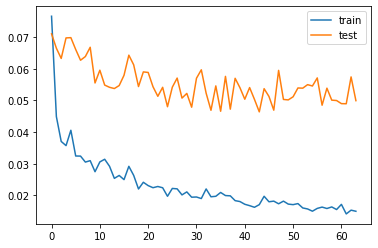

(71, 7)
(71, 7)
(71, 7)
score_train: [12.496] 13.9, 12.6, 13.3, 13.5, 11.9, 11.3, 10.8
(15, 1, 35)
score_test: [26.139] 29.2, 23.6, 32.8, 42.2, 9.1, 12.8, 16.4

RMSE test:  26.13877678205161 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0802
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0384 - val_loss: 0.1037
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0920
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0739
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0768
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0769
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0873
Epoch 8/1000
71/71 [=====================

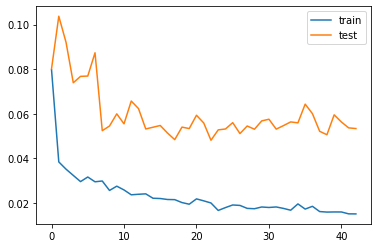

(71, 7)
(71, 7)
(71, 7)
score_train: [12.457] 12.7, 12.7, 13.3, 12.5, 11.9, 12.3, 11.9
(15, 1, 35)
score_test: [27.021] 26.3, 33.1, 30.7, 39.4, 24.5, 9.2, 11.9

RMSE test:  27.021060447968896 


Units CNN1:  63 Units CNN2:  95 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.1016 - val_loss: 0.0510
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0494 - val_loss: 0.0638
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0412 - val_loss: 0.0695
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0716
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0386 - val_loss: 0.0718
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0669
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0627
Epoch 8/1000
71/71 [======================

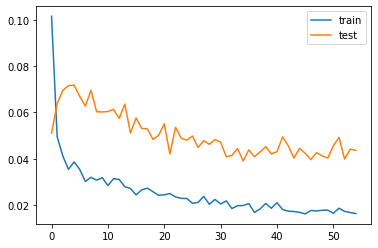

(71, 7)
(71, 7)
(71, 7)
score_train: [13.508] 14.6, 14.8, 14.5, 12.6, 12.6, 12.0, 13.3
(15, 1, 35)
score_test: [24.421] 11.5, 29.4, 37.8, 34.8, 2.8, 16.7, 15.8

RMSE test:  24.421120819357895 


Units CNN1:  107 Units CNN2:  126 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0681
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0390 - val_loss: 0.0828
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0707
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0765
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0613
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0686
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0676
Epoch 8/1000
71/71 [====================

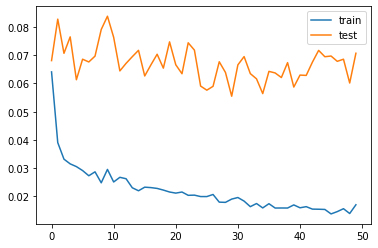

(71, 7)
(71, 7)
(71, 7)
score_train: [12.104] 13.7, 12.9, 13.2, 11.8, 11.3, 10.3, 11.2
(15, 1, 35)
score_test: [31.116] 15.2, 36.2, 30.4, 54.6, 22.4, 21.7, 18.8

RMSE test:  31.116392509223328 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0767 - val_loss: 0.0808
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0397 - val_loss: 0.1006
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0821
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0671
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0798
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0804
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0681
Epoch 8/1000
71/71 [===================

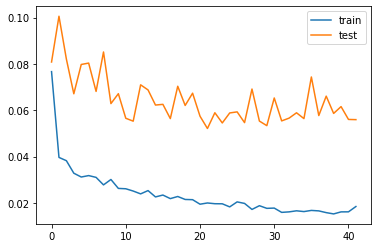

(71, 7)
(71, 7)
(71, 7)
score_train: [12.741] 14.3, 13.1, 13.4, 12.2, 12.2, 11.7, 12.0
(15, 1, 35)
score_test: [27.679] 24.6, 36.1, 33.3, 40.0, 12.8, 18.8, 15.1

RMSE test:  27.67862756527371 


Units CNN1:  127 Units CNN2:  119 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0887
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0395 - val_loss: 0.0791
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0744
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0664
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0549
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0585
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0261 - val_loss: 0.0568
Epoch 8/1000
71/71 [====================

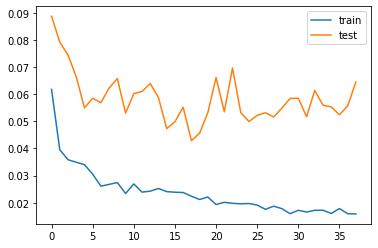

(71, 7)
(71, 7)
(71, 7)
score_train: [12.922] 13.0, 13.2, 13.3, 12.7, 13.3, 12.7, 12.2
(15, 1, 35)
score_test: [29.711] 28.8, 31.9, 32.2, 51.3, 7.7, 14.8, 19.4

RMSE test:  29.71076802596007 


Units CNN1:  125 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0757
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0363 - val_loss: 0.0954
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0722
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0763
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0605
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0586
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0520
Epoch 8/1000
71/71 [=====================

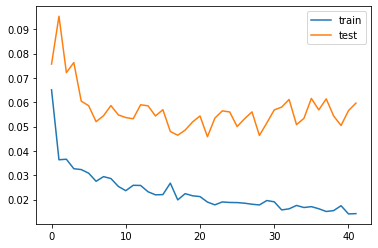

(71, 7)
(71, 7)
(71, 7)
score_train: [12.426] 13.3, 12.3, 13.5, 12.3, 11.6, 11.5, 12.5
(15, 1, 35)
score_test: [28.572] 30.1, 29.8, 28.5, 48.3, 14.9, 16.3, 17.0

RMSE test:  28.571515857235465 


Units CNN1:  118 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0740
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0369 - val_loss: 0.0830
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0656
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0767
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0604
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0581
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0251 - val_loss: 0.0625
Epoch 8/1000
71/71 [===================

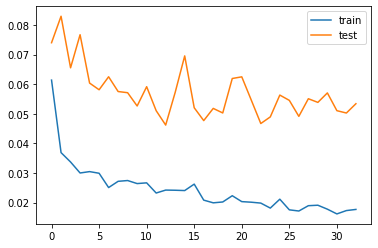

(71, 7)
(71, 7)
(71, 7)
score_train: [13.435] 13.4, 14.1, 14.6, 13.9, 13.6, 12.3, 12.1
(15, 1, 35)
score_test: [27.042] 36.7, 34.4, 29.2, 33.2, 6.7, 13.6, 19.9

RMSE test:  27.04179850289472 


Units CNN1:  31 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0943 - val_loss: 0.0754
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0506 - val_loss: 0.0823
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0439 - val_loss: 0.0922
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0415 - val_loss: 0.1046
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0384 - val_loss: 0.0817
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0402 - val_loss: 0.0785
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0820
Epoch 8/1000
71/71 [======================

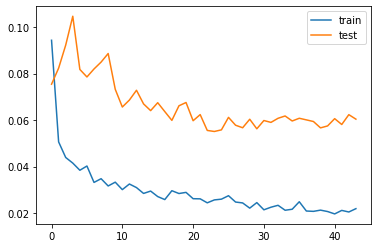

(71, 7)
(71, 7)
(71, 7)
score_train: [14.818] 15.2, 14.9, 15.3, 14.2, 15.5, 14.5, 14.0
(15, 1, 35)
score_test: [28.745] 28.2, 23.2, 40.0, 42.1, 13.4, 28.5, 9.5

RMSE test:  28.745106230958978 


Units CNN1:  103 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0729
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0399 - val_loss: 0.0674
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0745
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0673
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0684
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0621
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0681
Epoch 8/1000
71/71 [====================

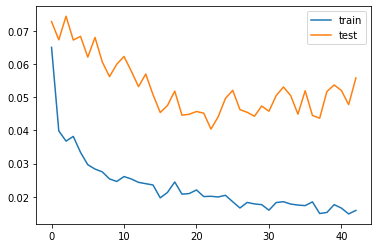

(71, 7)
(71, 7)
(71, 7)
score_train: [12.266] 12.9, 12.4, 13.1, 11.3, 12.1, 11.5, 12.4
(15, 1, 35)
score_test: [27.648] 18.9, 34.3, 30.5, 46.6, 9.3, 16.1, 19.4

RMSE test:  27.648208524731555 

gen	nevals	avg    	std     	min    	max    
0  	10    	24.7647	0.687062	24.4211	26.1388

Units CNN1:  95 Units CNN2:  126 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0672
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0660
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0664
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0656
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0578
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0588
Epoch 7/1000
71/71 [==============================] -

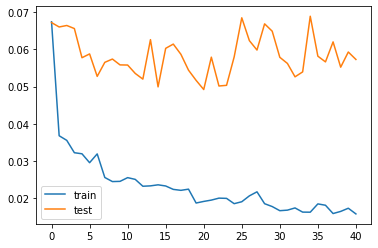

(71, 7)
(71, 7)
(71, 7)
score_train: [12.859] 13.5, 14.3, 13.4, 12.8, 12.3, 11.8, 11.6
(15, 1, 35)
score_test: [28.006] 19.5, 45.6, 35.6, 39.2, 9.8, 8.2, 7.9

RMSE test:  28.005849709788965 


Units CNN1:  111 Units CNN2:  94 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0754 - val_loss: 0.0801
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0856
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0771
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0841
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0706
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0656
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0700
Epoch 8/1000
71/71 [=======================

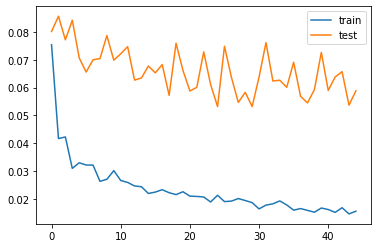

(71, 7)
(71, 7)
(71, 7)
score_train: [12.255] 12.4, 12.9, 13.2, 12.0, 12.0, 11.4, 11.7
(15, 1, 35)
score_test: [28.379] 33.6, 30.3, 33.0, 39.6, 21.8, 16.8, 13.4

RMSE test:  28.3793573605803 


Units CNN1:  111 Units CNN2:  63 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0629
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0392 - val_loss: 0.0645
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0643
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0604
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0737
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0707
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0677
Epoch 8/1000
71/71 [======================

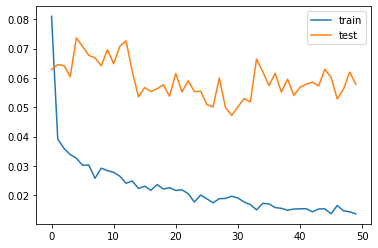

(71, 7)
(71, 7)
(71, 7)
score_train: [11.685] 12.8, 12.2, 12.9, 11.9, 10.8, 11.0, 10.0
(15, 1, 35)
score_test: [28.136] 27.6, 34.5, 31.6, 40.2, 16.9, 17.6, 19.4

RMSE test:  28.135741566391175 


Units CNN1:  123 Units CNN2:  31 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0754 - val_loss: 0.0823
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0418 - val_loss: 0.0940
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0899
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.0747
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0701
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0667
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0605
Epoch 8/1000
71/71 [====================

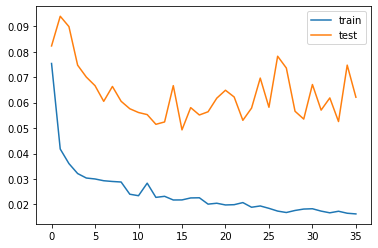

(71, 7)
(71, 7)
(71, 7)
score_train: [12.990] 13.3, 13.1, 13.6, 13.5, 13.4, 12.0, 11.9
(15, 1, 35)
score_test: [29.163] 26.9, 33.5, 33.2, 47.5, 7.6, 17.5, 19.4

RMSE test:  29.163443315508257 


Units CNN1:  125 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 6ms/step - loss: 0.0709 - val_loss: 0.0666
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0386 - val_loss: 0.0773
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0683
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0676
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0812
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0803
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0639
Epoch 8/1000
71/71 [====================

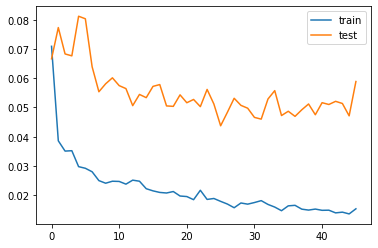

(71, 7)
(71, 7)
(71, 7)
score_train: [13.720] 14.4, 14.0, 14.7, 15.2, 13.0, 12.4, 11.9
(15, 1, 35)
score_test: [28.387] 22.6, 35.7, 27.4, 44.1, 19.8, 18.5, 20.7

RMSE test:  28.38677656410509 


Units CNN1:  62 Units CNN2:  126 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0780
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0452 - val_loss: 0.0848
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0398 - val_loss: 0.0809
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0387 - val_loss: 0.0809
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0750
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0848
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0731
Epoch 8/1000
71/71 [=====================

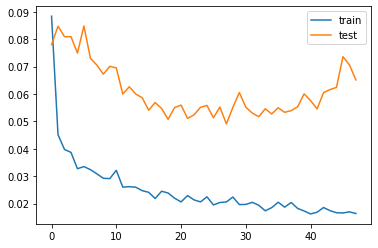

(71, 7)
(71, 7)
(71, 7)
score_train: [13.526] 14.6, 14.2, 14.5, 13.5, 12.7, 12.5, 12.6
(15, 1, 35)
score_test: [29.864] 14.1, 38.9, 37.7, 41.4, 18.6, 28.0, 16.3

RMSE test:  29.86401949862568 


Units CNN1:  127 Units CNN2:  119 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0638 - val_loss: 0.0912
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0820
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0812
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0777
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0760
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0751
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0745
Epoch 8/1000
71/71 [====================

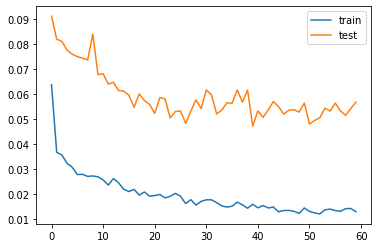

(71, 7)
(71, 7)
(71, 7)
score_train: [11.174] 12.1, 11.5, 11.8, 11.1, 10.7, 10.5, 10.4
(15, 1, 35)
score_test: [27.906] 31.6, 24.6, 29.2, 43.3, 23.0, 23.4, 6.7

RMSE test:  27.905599942230516 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.1009
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.1188
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0960
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0794
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0687
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0718
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0699
Epoch 8/1000
71/71 [====================

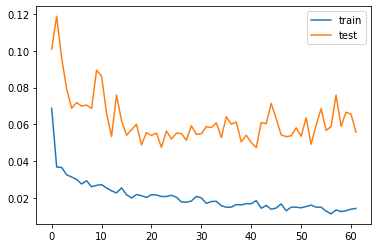

(71, 7)
(71, 7)
(71, 7)
score_train: [11.797] 12.4, 12.6, 12.3, 12.5, 11.2, 10.6, 10.8
(15, 1, 35)
score_test: [27.603] 27.5, 35.1, 33.1, 40.5, 12.9, 11.4, 17.7

RMSE test:  27.603480404148137 


Units CNN1:  125 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0568
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0429 - val_loss: 0.0882
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0676
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0681
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0695
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0689
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0778
Epoch 8/1000
71/71 [===================

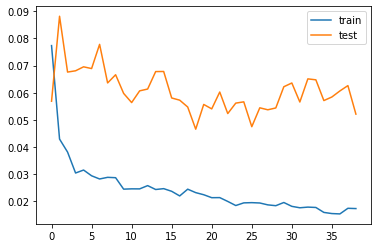

(71, 7)
(71, 7)
(71, 7)
score_train: [13.662] 13.3, 15.5, 14.3, 14.0, 13.6, 12.3, 12.4
(15, 1, 35)
score_test: [26.702] 27.9, 39.9, 31.2, 35.8, 13.4, 13.4, 2.1

RMSE test:  26.70232183362398 

1  	9     	24.4211	0       	24.4211	24.4211

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0674 - val_loss: 0.0638
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0727
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0847
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0836
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0757
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0609
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.06

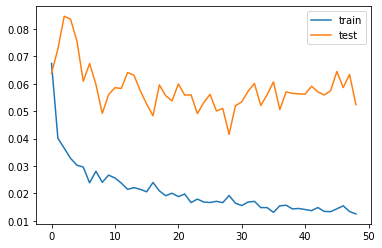

(71, 7)
(71, 7)
(71, 7)
score_train: [11.510] 11.9, 12.9, 11.8, 11.1, 11.2, 10.8, 10.8
(15, 1, 35)
score_test: [26.781] 29.9, 33.5, 31.1, 37.5, 14.1, 15.0, 14.3

RMSE test:  26.78081378733942 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0779 - val_loss: 0.0783
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0403 - val_loss: 0.0707
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0767
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0676
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0660
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0789
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0765
Epoch 8/1000
71/71 [====================

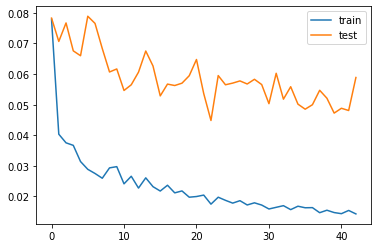

(71, 7)
(71, 7)
(71, 7)
score_train: [12.064] 12.4, 12.4, 13.2, 12.1, 11.4, 12.0, 10.7
(15, 1, 35)
score_test: [28.389] 26.6, 37.1, 32.8, 40.7, 13.7, 21.2, 13.6

RMSE test:  28.389245403749637 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0741 - val_loss: 0.0641
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0397 - val_loss: 0.0673
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0824
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0729
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0653
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0595
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0712
Epoch 8/1000
71/71 [===================

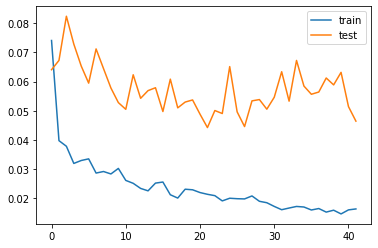

(71, 7)
(71, 7)
(71, 7)
score_train: [13.627] 13.4, 13.9, 13.6, 14.8, 13.8, 12.6, 13.1
(15, 1, 35)
score_test: [25.205] 20.7, 37.8, 32.6, 35.0, 10.6, 12.6, 5.5

RMSE test:  25.20472790111334 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0518
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0602
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0653
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0876
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0697
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0676
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0689
Epoch 8/1000
71/71 [=====================

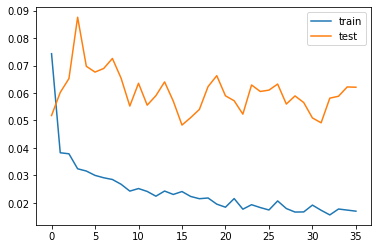

(71, 7)
(71, 7)
(71, 7)
score_train: [13.148] 14.0, 13.7, 14.2, 13.0, 12.4, 12.1, 12.4
(15, 1, 35)
score_test: [29.158] 33.2, 28.4, 38.8, 43.7, 11.1, 11.5, 19.5

RMSE test:  29.15812962052643 


Units CNN1:  111 Units CNN2:  30 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0838
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0401 - val_loss: 0.0861
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0401 - val_loss: 0.1026
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0812
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0743
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0868
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0868
Epoch 8/1000
71/71 [=====================

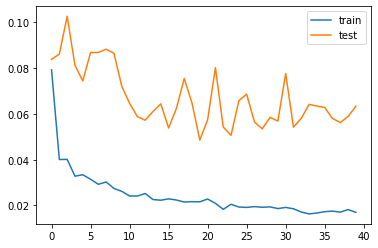

(71, 7)
(71, 7)
(71, 7)
score_train: [12.962] 13.2, 14.9, 14.2, 13.1, 12.4, 11.2, 11.3
(15, 1, 35)
score_test: [29.443] 41.2, 22.5, 32.4, 41.4, 22.6, 16.5, 17.7

RMSE test:  29.442590500046663 


Units CNN1:  127 Units CNN2:  109 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0613
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0401 - val_loss: 0.0745
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0888
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0792
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0632
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0817
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0625
Epoch 8/1000
71/71 [===================

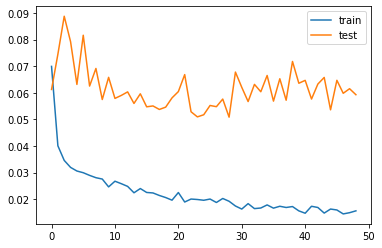

(71, 7)
(71, 7)
(71, 7)
score_train: [12.147] 12.5, 12.7, 12.9, 12.4, 11.6, 11.1, 11.7
(15, 1, 35)
score_test: [28.489] 17.3, 42.0, 32.1, 41.7, 20.8, 16.5, 11.8

RMSE test:  28.488807748697443 


Units CNN1:  118 Units CNN2:  126 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0793 - val_loss: 0.0865
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0414 - val_loss: 0.0747
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0403 - val_loss: 0.0719
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0697
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0804
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0698
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0787
Epoch 8/1000
71/71 [===================

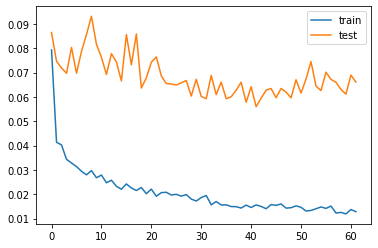

(71, 7)
(71, 7)
(71, 7)
score_train: [11.668] 12.2, 11.7, 12.0, 12.0, 11.9, 11.5, 10.3
(15, 1, 35)
score_test: [30.083] 27.8, 36.2, 36.1, 50.2, 9.2, 15.6, 10.1

RMSE test:  30.082952284552434 


Units CNN1:  127 Units CNN2:  124 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0747 - val_loss: 0.0593
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0412 - val_loss: 0.0721
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0695
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0688
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0674
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0703
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0714
Epoch 8/1000
71/71 [====================

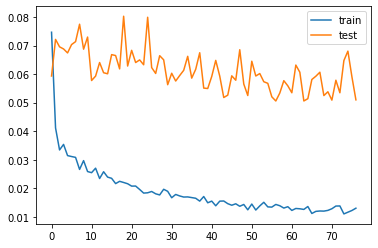

(71, 7)
(71, 7)
(71, 7)
score_train: [11.848] 13.3, 12.6, 12.7, 11.8, 11.2, 10.5, 10.5
(15, 1, 35)
score_test: [26.418] 32.7, 29.8, 30.9, 35.8, 11.1, 21.0, 11.0

RMSE test:  26.41776985475378 


Units CNN1:  63 Units CNN2:  126 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0749
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0443 - val_loss: 0.0711
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0372 - val_loss: 0.0739
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0631
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0651
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0580
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0569
Epoch 8/1000
71/71 [=====================

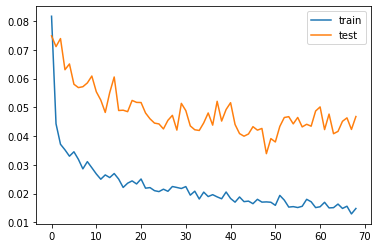

(71, 7)
(71, 7)
(71, 7)
score_train: [12.160] 12.6, 12.5, 13.1, 12.0, 11.6, 11.4, 11.8
(15, 1, 35)
score_test: [25.315] 20.3, 16.4, 42.5, 34.7, 15.1, 20.5, 12.2

RMSE test:  25.31520907061613 


Units CNN1:  94 Units CNN2:  126 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0996 - val_loss: 0.0608
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0419 - val_loss: 0.0679
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0657
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0682
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0638
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0602
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0574
Epoch 8/1000
71/71 [=====================

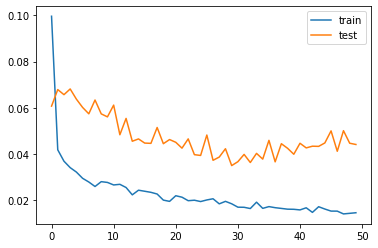

(71, 7)
(71, 7)
(71, 7)
score_train: [12.381] 12.8, 13.1, 14.0, 11.4, 11.8, 11.5, 11.8
(15, 1, 35)
score_test: [24.591] 15.4, 23.9, 34.5, 39.9, 5.4, 18.7, 16.1

RMSE test:  24.59118971671589 

2  	10    	24.4211	0       	24.4211	24.4211

Units CNN1:  60 Units CNN2:  13 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 7ms/step - loss: 0.0714 - val_loss: 0.0480
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0461 - val_loss: 0.0540
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0416 - val_loss: 0.0652
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0610
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0709
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0389 - val_loss: 0.0873
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0689

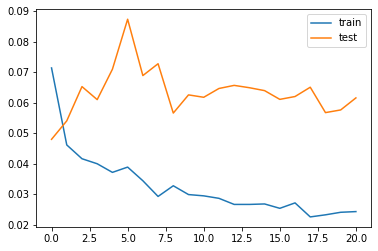

(71, 7)
(71, 7)
(71, 7)
score_train: [15.576] 15.7, 15.1, 16.5, 15.7, 16.2, 15.8, 14.0
(15, 1, 35)
score_test: [29.024] 27.0, 31.3, 42.7, 40.6, 19.5, 9.3, 15.6

RMSE test:  29.023999977117242 


Units CNN1:  111 Units CNN2:  125 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0598 - val_loss: 0.1001
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0830
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0765
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0408 - val_loss: 0.0725
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0735
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0695
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0606
Epoch 8/1000
71/71 [====================

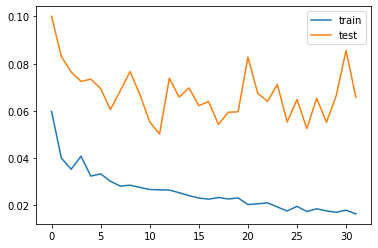

(71, 7)
(71, 7)
(71, 7)
score_train: [13.251] 13.8, 13.3, 14.3, 13.4, 13.3, 12.1, 12.5
(15, 1, 35)
score_test: [29.990] 34.1, 31.5, 34.5, 43.7, 11.2, 19.3, 23.1

RMSE test:  29.98995868939789 


Units CNN1:  126 Units CNN2:  123 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0920 - val_loss: 0.0758
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0367 - val_loss: 0.0781
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0841
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0821
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0898
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0768
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0751
Epoch 8/1000
71/71 [====================

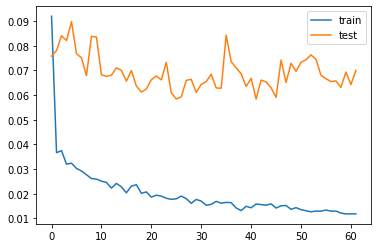

(71, 7)
(71, 7)
(71, 7)
score_train: [11.814] 11.2, 12.3, 12.6, 12.1, 10.5, 11.2, 12.6
(15, 1, 35)
score_test: [30.957] 29.3, 45.6, 38.1, 42.6, 18.7, 9.5, 8.6

RMSE test:  30.956648509096183 


Units CNN1:  119 Units CNN2:  109 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0750
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0710
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0710
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0791
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0912
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0727
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0753
Epoch 8/1000
71/71 [=====================

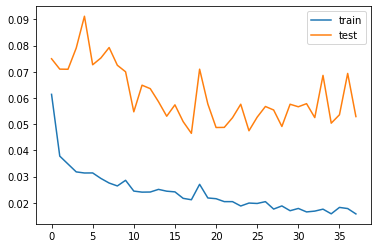

(71, 7)
(71, 7)
(71, 7)
score_train: [13.442] 14.5, 14.2, 13.7, 13.5, 13.9, 11.9, 12.1
(15, 1, 35)
score_test: [26.907] 24.7, 33.4, 40.1, 36.1, 9.5, 16.2, 8.6

RMSE test:  26.907495082256975 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0814 - val_loss: 0.0772
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0414 - val_loss: 0.0746
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0816
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0638
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0665
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0758
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0518
Epoch 8/1000
71/71 [=====================

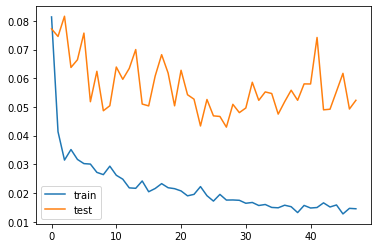

(71, 7)
(71, 7)
(71, 7)
score_train: [12.212] 12.7, 13.3, 13.5, 12.2, 11.6, 10.9, 11.0
(15, 1, 35)
score_test: [26.766] 34.0, 20.4, 34.5, 41.9, 10.4, 14.3, 13.6

RMSE test:  26.765940592991477 


Units CNN1:  111 Units CNN2:  123 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0761 - val_loss: 0.0823
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0899
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0832
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0837
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.0730
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0911
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0777
Epoch 8/1000
71/71 [===================

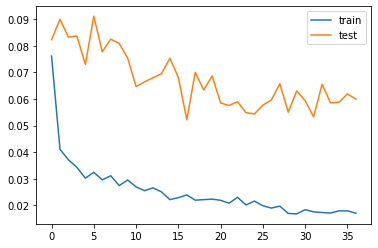

(71, 7)
(71, 7)
(71, 7)
score_train: [12.830] 12.9, 13.7, 13.6, 12.6, 12.5, 12.1, 12.2
(15, 1, 35)
score_test: [28.640] 31.2, 33.8, 41.4, 34.6, 10.1, 18.4, 16.6

RMSE test:  28.640413120854088 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0866 - val_loss: 0.0770
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0928
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0913
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0998
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0925
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0767
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0716
Epoch 8/1000
71/71 [===================

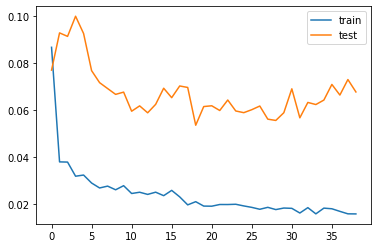

(71, 7)
(71, 7)
(71, 7)
score_train: [12.334] 12.9, 12.9, 13.2, 12.7, 12.1, 10.8, 11.4
(15, 1, 35)
score_test: [30.441] 28.4, 37.1, 31.4, 44.5, 11.6, 28.5, 19.5

RMSE test:  30.441262890842744 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0687 - val_loss: 0.0925
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0386 - val_loss: 0.0880
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0333 - val_loss: 0.0852
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0819
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0852
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0726
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0865
Epoch 8/1000
71/71 [===================

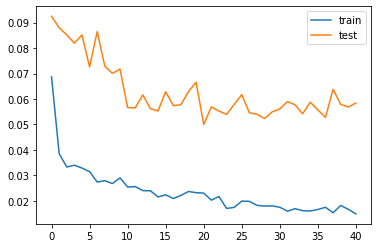

(71, 7)
(71, 7)
(71, 7)
score_train: [12.224] 12.7, 12.7, 13.0, 12.6, 11.8, 11.1, 11.5
(15, 1, 35)
score_test: [28.277] 35.4, 33.7, 32.6, 39.4, 11.2, 13.0, 17.2

RMSE test:  28.277231993367188 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 7ms/step - loss: 0.0679 - val_loss: 0.0757
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0391 - val_loss: 0.0909
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0756
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0802
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0824
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0679
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0704
Epoch 8/1000
71/71 [===================

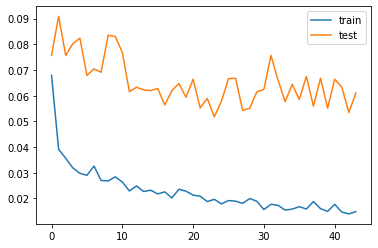

(71, 7)
(71, 7)
(71, 7)
score_train: [12.412] 12.9, 12.7, 13.3, 12.5, 12.3, 11.4, 11.7
(15, 1, 35)
score_test: [28.903] 36.8, 31.9, 31.8, 42.6, 13.6, 19.5, 9.4

RMSE test:  28.902887205550446 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0599
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0374 - val_loss: 0.0712
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0719
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0690
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0592
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0620
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0667
Epoch 8/1000
71/71 [====================

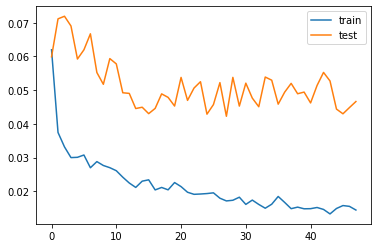

(71, 7)
(71, 7)
(71, 7)
score_train: [11.782] 12.7, 12.4, 12.2, 11.4, 11.6, 10.6, 11.4
(15, 1, 35)
score_test: [25.261] 19.1, 27.7, 31.6, 40.6, 24.1, 9.6, 4.3

RMSE test:  25.261032031169663 

3  	10    	24.4211	0       	24.4211	24.4211

Units CNN1:  123 Units CNN2:  119 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0678 - val_loss: 0.0635
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0804
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0987
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0691
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0665
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0824
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.07

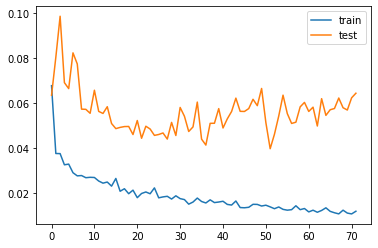

(71, 7)
(71, 7)
(71, 7)
score_train: [10.525] 11.7, 10.7, 11.1, 10.3, 10.1, 9.6, 10.0
(15, 1, 35)
score_test: [29.694] 31.5, 27.5, 35.1, 43.6, 20.3, 20.2, 21.9

RMSE test:  29.694385341485027 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0690 - val_loss: 0.0865
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0887
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0770
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0792
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0730
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0690
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0622
Epoch 8/1000
71/71 [====================

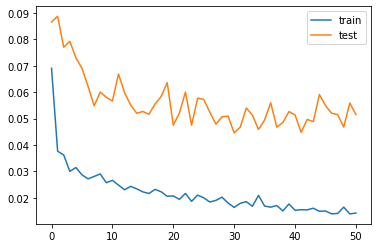

(71, 7)
(71, 7)
(71, 7)
score_train: [12.049] 12.4, 13.1, 12.8, 12.4, 11.7, 10.5, 11.3
(15, 1, 35)
score_test: [26.565] 26.3, 31.1, 28.8, 38.9, 21.2, 19.2, 11.0

RMSE test:  26.56499529451735 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0674 - val_loss: 0.0918
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.1000
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0374 - val_loss: 0.0947
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0997
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0752
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0823
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0833
Epoch 8/1000
71/71 [====================

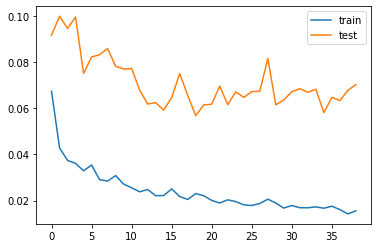

(71, 7)
(71, 7)
(71, 7)
score_train: [12.362] 12.7, 13.2, 13.4, 12.6, 11.9, 11.7, 10.8
(15, 1, 35)
score_test: [31.025] 27.6, 36.4, 33.4, 46.4, 19.6, 21.1, 23.6

RMSE test:  31.025496219400438 


Units CNN1:  115 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0807
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0407 - val_loss: 0.0641
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0378 - val_loss: 0.0818
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0542
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0618
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0516
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0528
Epoch 8/1000
71/71 [===================

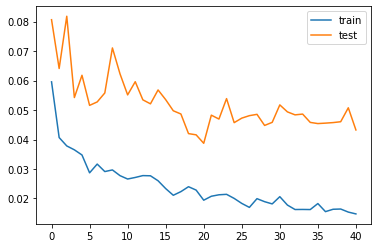

(71, 7)
(71, 7)
(71, 7)
score_train: [13.144] 12.9, 13.4, 13.8, 13.7, 12.9, 12.6, 12.5
(15, 1, 35)
score_test: [24.329] 17.3, 27.0, 31.7, 34.9, 24.3, 9.3, 14.7

RMSE test:  24.329106205730973 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0595 - val_loss: 0.0631
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0664
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0580
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0664
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0586
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0510
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0502
Epoch 8/1000
71/71 [====================

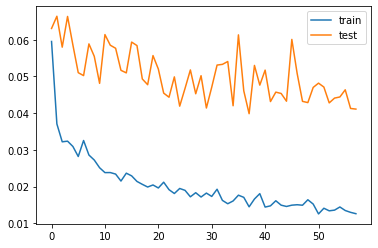

(71, 7)
(71, 7)
(71, 7)
score_train: [11.536] 12.4, 12.5, 12.8, 11.6, 10.4, 10.9, 9.8
(15, 1, 35)
score_test: [23.724] 24.3, 22.1, 33.8, 32.1, 18.2, 13.7, 13.1

RMSE test:  23.723832170391304 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0870
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0394 - val_loss: 0.1036
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0807
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0788
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0664
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.0681
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0631
Epoch 8/1000
71/71 [====================

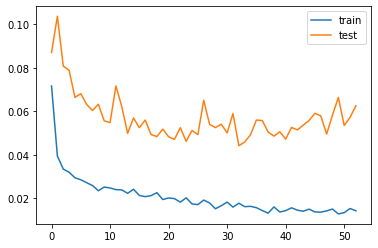

(71, 7)
(71, 7)
(71, 7)
score_train: [11.626] 12.2, 12.9, 12.1, 11.0, 11.1, 11.1, 10.8
(15, 1, 35)
score_test: [29.260] 22.3, 32.1, 28.9, 48.9, 26.9, 20.6, 9.3

RMSE test:  29.2595716517696 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 7ms/step - loss: 0.0736 - val_loss: 0.0837
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0392 - val_loss: 0.0862
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0749
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0708
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0554
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0638
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0625
Epoch 8/1000
71/71 [======================

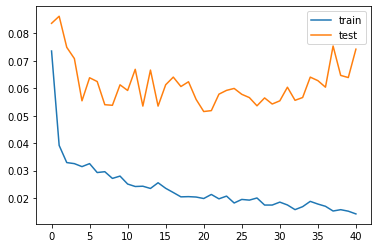

(71, 7)
(71, 7)
(71, 7)
score_train: [12.984] 12.9, 12.7, 14.6, 13.5, 11.7, 12.8, 12.4
(15, 1, 35)
score_test: [31.881] 23.8, 39.0, 28.4, 52.5, 21.8, 23.9, 20.5

RMSE test:  31.88055390976786 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0610 - val_loss: 0.0679
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0400 - val_loss: 0.0736
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0722
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0651
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0660
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0602
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0648
Epoch 8/1000
71/71 [====================

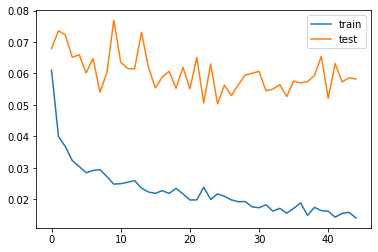

(71, 7)
(71, 7)
(71, 7)
score_train: [12.518] 13.7, 13.1, 13.5, 11.9, 11.6, 11.7, 11.8
(15, 1, 35)
score_test: [28.238] 28.1, 32.2, 37.6, 38.4, 13.4, 23.6, 11.5

RMSE test:  28.2384289100887 

4  	8     	24.133 	0.335142	23.7238	24.4211

Units CNN1:  127 Units CNN2:  119 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0776
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0425 - val_loss: 0.0831
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0816
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0760
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0815
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0724
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.06

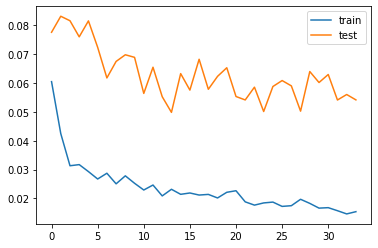

(71, 7)
(71, 7)
(71, 7)
score_train: [14.203] 14.4, 16.0, 15.5, 13.6, 14.1, 12.3, 13.2
(15, 1, 35)
score_test: [27.227] 26.2, 38.1, 32.7, 37.3, 17.3, 15.3, 7.9

RMSE test:  27.227130768110147 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0861
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0442 - val_loss: 0.0970
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0416 - val_loss: 0.1003
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0354 - val_loss: 0.0819
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0801
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0806
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0759
Epoch 8/1000
71/71 [====================

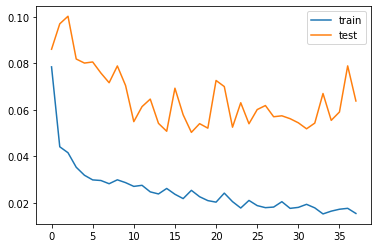

(71, 7)
(71, 7)
(71, 7)
score_train: [12.689] 12.9, 12.9, 14.5, 12.8, 12.9, 11.3, 11.2
(15, 1, 35)
score_test: [29.560] 29.7, 35.4, 33.5, 42.9, 5.9, 25.7, 17.9

RMSE test:  29.55965588032989 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0763 - val_loss: 0.0653
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0584
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0618
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0607
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0570
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0595
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0635
Epoch 8/1000
71/71 [=====================

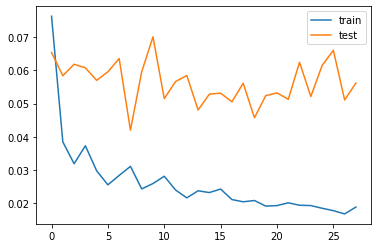

(71, 7)
(71, 7)
(71, 7)
score_train: [13.556] 13.9, 13.9, 14.6, 13.9, 13.1, 12.7, 12.7
(15, 1, 35)
score_test: [27.726] 26.8, 29.8, 32.6, 41.1, 16.7, 22.3, 15.8

RMSE test:  27.725566372379106 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0594 - val_loss: 0.0720
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0389 - val_loss: 0.0961
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0372 - val_loss: 0.0855
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0364 - val_loss: 0.0750
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0766
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0871
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.0786
Epoch 8/1000
71/71 [===================

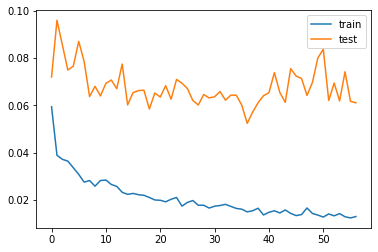

(71, 7)
(71, 7)
(71, 7)
score_train: [12.752] 12.5, 15.3, 13.3, 12.3, 12.0, 12.1, 11.4
(15, 1, 35)
score_test: [28.920] 39.7, 32.1, 28.8, 40.3, 18.5, 15.6, 14.3

RMSE test:  28.919990732036727 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0884
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0381 - val_loss: 0.0788
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0890
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0763
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0777
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0771
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0630
Epoch 8/1000
71/71 [===================

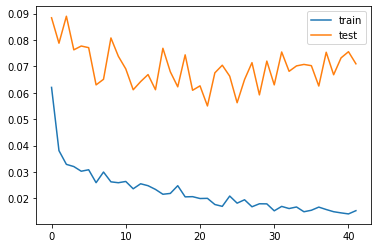

(71, 7)
(71, 7)
(71, 7)
score_train: [12.539] 14.0, 12.8, 13.2, 12.2, 11.5, 11.8, 12.0
(15, 1, 35)
score_test: [31.169] 27.2, 44.1, 38.2, 41.2, 23.8, 13.5, 14.4

RMSE test:  31.169124432408005 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0872 - val_loss: 0.0810
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0442 - val_loss: 0.0742
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0834
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0740
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0762
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0756
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0779
Epoch 8/1000
71/71 [===================

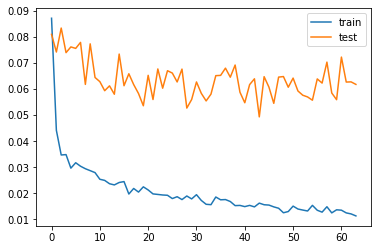

(71, 7)
(71, 7)
(71, 7)
score_train: [11.230] 11.4, 11.4, 12.5, 11.6, 11.2, 9.7, 10.6
(15, 1, 35)
score_test: [29.088] 26.7, 33.9, 27.8, 42.2, 12.6, 29.0, 22.3

RMSE test:  29.08755526271486 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 7ms/step - loss: 0.0571 - val_loss: 0.0740
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.0711
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0663
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0725
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0736
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0607
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0736
Epoch 8/1000
71/71 [=====================

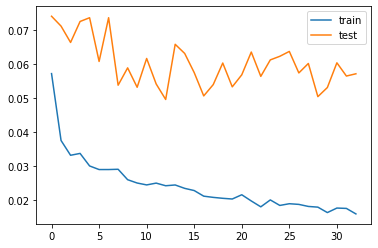

(71, 7)
(71, 7)
(71, 7)
score_train: [13.415] 13.5, 13.9, 14.9, 12.8, 13.3, 12.2, 13.3
(15, 1, 35)
score_test: [27.957] 20.0, 33.2, 36.0, 46.6, 14.9, 9.7, 13.5

RMSE test:  27.956708770933655 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0620 - val_loss: 0.0980
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0818
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.1005
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0864
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0666
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0843
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0744
Epoch 8/1000
71/71 [====================

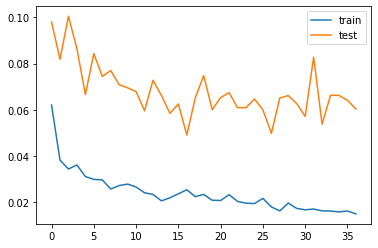

(71, 7)
(71, 7)
(71, 7)
score_train: [12.972] 13.9, 12.7, 13.5, 12.3, 13.9, 12.4, 11.9
(15, 1, 35)
score_test: [28.727] 19.4, 32.6, 33.8, 51.5, 14.2, 16.1, 9.1

RMSE test:  28.726517528951934 

5  	8     	23.7936	0.209187	23.7238	24.4211

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0715 - val_loss: 0.0846
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0396 - val_loss: 0.0693
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0729
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0747
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0784
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0805
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0

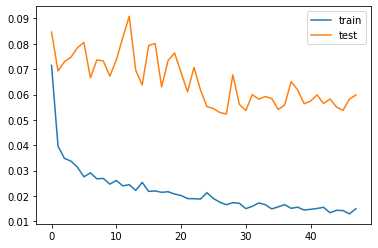

(71, 7)
(71, 7)
(71, 7)
score_train: [12.099] 13.2, 12.5, 13.2, 11.7, 12.0, 11.1, 10.7
(15, 1, 35)
score_test: [28.615] 27.6, 33.9, 32.9, 40.2, 14.9, 21.5, 20.9

RMSE test:  28.615392823014652 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0918
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0375 - val_loss: 0.1040
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0888
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0986
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0750
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0698
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.0645
Epoch 8/1000
71/71 [===================

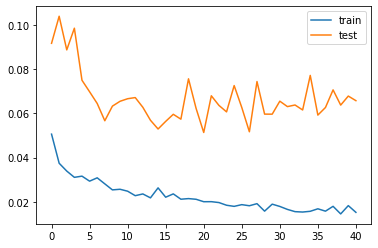

(71, 7)
(71, 7)
(71, 7)
score_train: [12.470] 12.9, 12.8, 13.2, 12.2, 12.9, 11.5, 11.7
(15, 1, 35)
score_test: [30.010] 35.4, 37.5, 30.8, 47.6, 12.4, 11.2, 12.5

RMSE test:  30.010280468640833 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0636
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0733
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0898
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0753
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0763
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0679
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0672
Epoch 8/1000
71/71 [===================

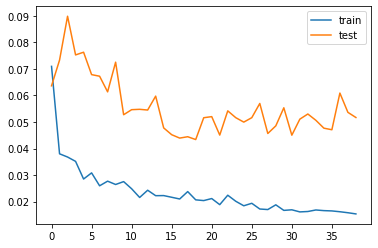

(71, 7)
(71, 7)
(71, 7)
score_train: [12.382] 13.3, 12.4, 13.8, 12.8, 11.6, 10.6, 11.8
(15, 1, 35)
score_test: [26.601] 24.9, 36.9, 28.5, 41.3, 9.1, 15.8, 11.0

RMSE test:  26.601394031907613 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0643
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0371 - val_loss: 0.0744
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0791
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0720
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0671
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0716
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0663
Epoch 8/1000
71/71 [====================

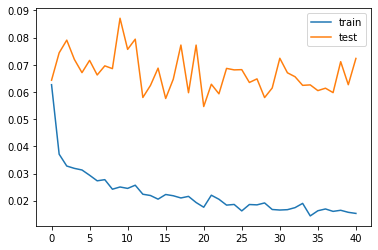

(71, 7)
(71, 7)
(71, 7)
score_train: [13.167] 13.3, 14.6, 14.9, 14.6, 12.0, 11.7, 10.5
(15, 1, 35)
score_test: [31.468] 37.2, 20.1, 37.9, 46.3, 26.2, 27.7, 10.6

RMSE test:  31.46751131744356 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0874
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0388 - val_loss: 0.0767
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0774
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0654
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0724
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0351 - val_loss: 0.0676
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0574
Epoch 8/1000
71/71 [====================

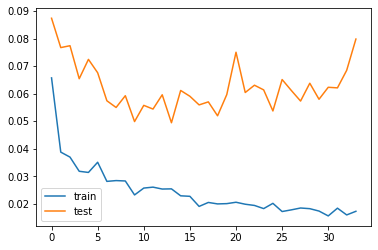

(71, 7)
(71, 7)
(71, 7)
score_train: [14.132] 14.6, 13.3, 15.1, 16.0, 14.0, 12.8, 12.9
(15, 1, 35)
score_test: [33.051] 38.1, 38.6, 28.9, 53.1, 16.0, 22.4, 16.8

RMSE test:  33.05115611404436 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0880
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0791
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0896
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0814
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0774
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0788
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0696
Epoch 8/1000
71/71 [====================

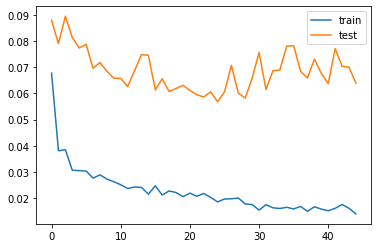

(71, 7)
(71, 7)
(71, 7)
score_train: [11.911] 13.1, 12.9, 12.2, 11.9, 11.5, 10.8, 10.8
(15, 1, 35)
score_test: [29.591] 28.2, 33.3, 35.4, 46.6, 20.0, 16.2, 11.7

RMSE test:  29.590646658111286 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 7ms/step - loss: 0.0689 - val_loss: 0.0734
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0398 - val_loss: 0.0697
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0748
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0656
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0783
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0695
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.0684
Epoch 8/1000
71/71 [===================

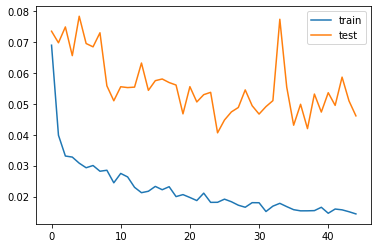

(71, 7)
(71, 7)
(71, 7)
score_train: [12.333] 13.2, 12.7, 13.0, 11.5, 12.5, 12.3, 10.9
(15, 1, 35)
score_test: [25.116] 19.7, 33.8, 32.0, 35.8, 18.1, 7.0, 14.2

RMSE test:  25.11598128415397 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0819
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0404 - val_loss: 0.0766
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0884
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0727
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.0710
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0650
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0673
Epoch 8/1000
71/71 [=====================

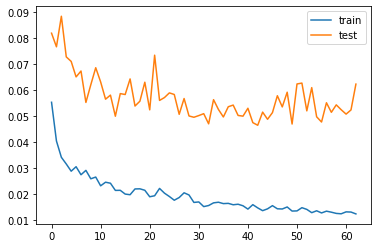

(71, 7)
(71, 7)
(71, 7)
score_train: [11.453] 12.1, 11.6, 12.6, 11.4, 10.5, 10.4, 11.5
(15, 1, 35)
score_test: [29.197] 18.5, 34.4, 32.4, 46.0, 19.5, 19.6, 22.5

RMSE test:  29.19688886155174 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0556
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0646
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0628
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0316 - val_loss: 0.0569
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0645
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0651
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0576
Epoch 8/1000
71/71 [====================

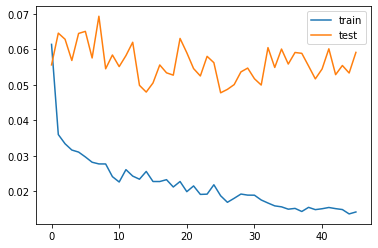

(71, 7)
(71, 7)
(71, 7)
score_train: [12.565] 14.5, 12.9, 13.1, 13.0, 11.6, 10.7, 11.7
(15, 1, 35)
score_test: [28.453] 29.3, 30.0, 37.0, 38.1, 9.2, 27.9, 15.0

RMSE test:  28.452601766611945 

6  	9     	23.7238	3.55271e-15	23.7238	23.7238

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0934
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0446 - val_loss: 0.0753
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0387 - val_loss: 0.0724
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0858
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0968
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0635
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 

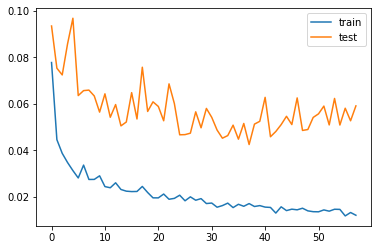

(71, 7)
(71, 7)
(71, 7)
score_train: [11.423] 12.8, 11.7, 11.9, 10.4, 11.2, 9.8, 11.8
(15, 1, 35)
score_test: [28.439] 40.8, 24.5, 28.7, 41.4, 11.9, 23.8, 12.1

RMSE test:  28.43925240369835 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0746 - val_loss: 0.0795
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0833
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0685
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0750
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0726
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.0577
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0585
Epoch 8/1000
71/71 [=====================

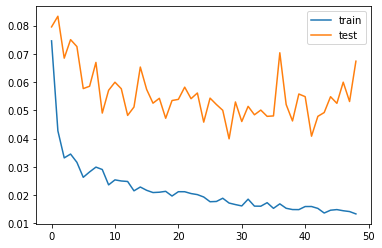

(71, 7)
(71, 7)
(71, 7)
score_train: [11.892] 12.7, 12.9, 12.1, 12.5, 11.5, 10.3, 10.9
(15, 1, 35)
score_test: [30.377] 23.5, 34.4, 25.8, 51.9, 19.9, 26.1, 16.9

RMSE test:  30.37659327634781 


Units CNN1:  126 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0630
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0407 - val_loss: 0.0714
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0784
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0705
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0728
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.0739
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0728
Epoch 8/1000
71/71 [====================

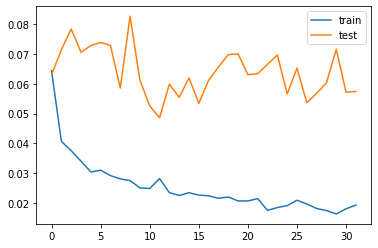

(71, 7)
(71, 7)
(71, 7)
score_train: [13.808] 14.5, 14.3, 14.1, 13.9, 13.9, 12.3, 13.6
(15, 1, 35)
score_test: [28.040] 20.8, 36.5, 37.0, 37.2, 5.4, 26.2, 16.6

RMSE test:  28.039609734332 


Units CNN1:  127 Units CNN2:  63 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0733 - val_loss: 0.0832
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0828
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0821
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0676
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0623
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0630
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0709
Epoch 8/1000
71/71 [========================

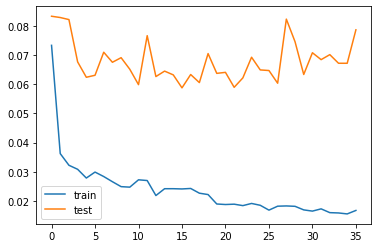

(71, 7)
(71, 7)
(71, 7)
score_train: [13.089] 13.6, 13.7, 14.2, 14.0, 13.1, 11.2, 11.4
(15, 1, 35)
score_test: [32.798] 29.2, 28.5, 41.0, 54.5, 23.6, 18.2, 18.2

RMSE test:  32.79752496170635 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0547
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0388 - val_loss: 0.0582
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0567
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0612
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0636
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0713
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0654
Epoch 8/1000
71/71 [====================

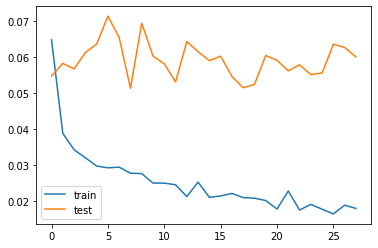

(71, 7)
(71, 7)
(71, 7)
score_train: [14.101] 13.4, 13.7, 15.7, 14.6, 13.7, 13.7, 13.8
(15, 1, 35)
score_test: [28.661] 36.0, 32.8, 37.4, 39.9, 11.8, 7.0, 14.3

RMSE test:  28.660756464809612 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0751 - val_loss: 0.0586
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0430 - val_loss: 0.0671
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0664
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0729
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0662
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0701
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0715
Epoch 8/1000
71/71 [====================

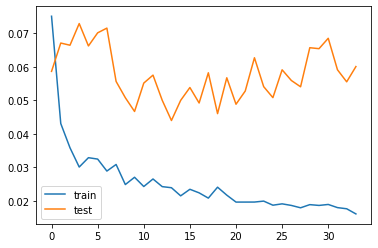

(71, 7)
(71, 7)
(71, 7)
score_train: [12.743] 13.3, 13.8, 13.5, 12.7, 12.2, 11.7, 11.7
(15, 1, 35)
score_test: [28.672] 23.8, 35.3, 30.2, 41.0, 7.7, 23.7, 26.9

RMSE test:  28.672378414880182 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0616
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0401 - val_loss: 0.0669
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0702
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0701
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0753
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0598
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0676
Epoch 8/1000
71/71 [====================

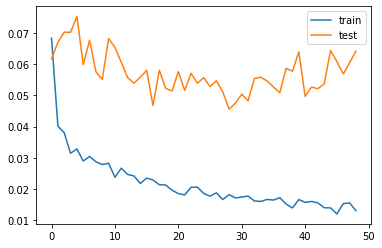

(71, 7)
(71, 7)
(71, 7)
score_train: [12.021] 12.8, 13.2, 12.5, 13.3, 10.9, 10.5, 10.6
(15, 1, 35)
score_test: [29.616] 26.4, 33.2, 34.0, 51.6, 14.8, 10.4, 14.2

RMSE test:  29.615938336068535 


Units CNN1:  127 Units CNN2:  95 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0769
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0344 - val_loss: 0.0765
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0903
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0696
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0832
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0660
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0743
Epoch 8/1000
71/71 [====================

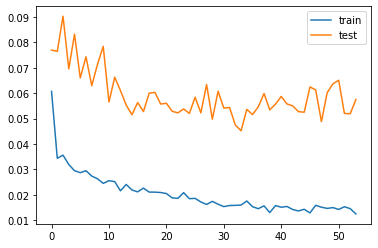

(71, 7)
(71, 7)
(71, 7)
score_train: [11.924] 12.6, 12.7, 12.9, 12.2, 11.2, 11.6, 9.9
(15, 1, 35)
score_test: [28.053] 25.1, 33.2, 26.3, 46.2, 14.4, 23.4, 14.0

RMSE test:  28.053043831678757 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0696
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0406 - val_loss: 0.0678
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0679
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0627
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0674
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0670
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0565
Epoch 8/1000
71/71 [====================

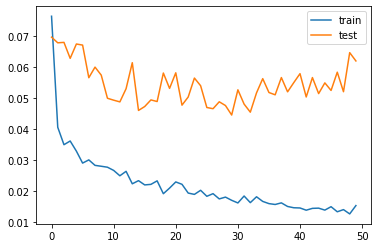

(71, 7)
(71, 7)
(71, 7)
score_train: [12.308] 15.3, 13.0, 12.9, 11.1, 11.3, 11.0, 10.9
(15, 1, 35)
score_test: [29.113] 20.3, 32.4, 29.8, 44.4, 17.4, 26.6, 24.5

RMSE test:  29.112640945815283 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0868 - val_loss: 0.0561
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0704
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0693
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0365 - val_loss: 0.0720
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0602
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0652
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0835
Epoch 8/1000
71/71 [===================

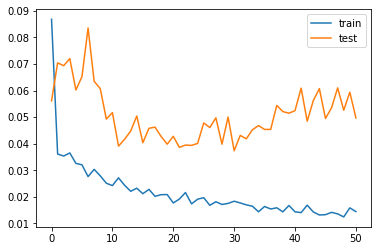

(71, 7)
(71, 7)
(71, 7)
score_train: [11.671] 12.4, 11.9, 12.3, 11.5, 11.5, 11.4, 10.6
(15, 1, 35)
score_test: [26.077] 24.1, 35.4, 25.6, 43.4, 11.2, 12.3, 10.3

RMSE test:  26.07673108293299 

7  	10    	23.7238	3.55271e-15	23.7238	23.7238

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0756 - val_loss: 0.0585
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0402 - val_loss: 0.0740
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0716
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0718
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0738
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0718
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 

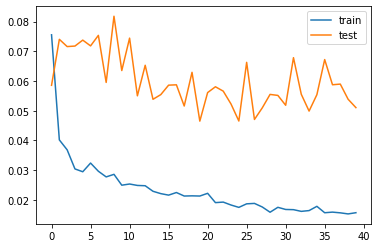

(71, 7)
(71, 7)
(71, 7)
score_train: [14.671] 16.0, 14.1, 16.1, 14.6, 15.1, 13.0, 13.6
(15, 1, 35)
score_test: [26.434] 20.9, 33.6, 34.0, 39.8, 14.3, 14.9, 12.6

RMSE test:  26.434253486033455 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0939 - val_loss: 0.0749
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0799
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0867
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0746
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0683
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.0744
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0622
Epoch 8/1000
71/71 [===================

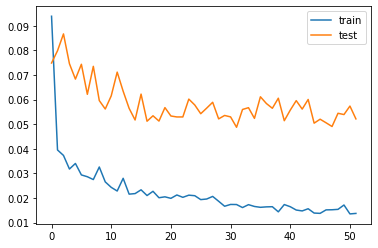

(71, 7)
(71, 7)
(71, 7)
score_train: [12.802] 12.5, 12.2, 15.7, 13.7, 13.0, 10.2, 11.7
(15, 1, 35)
score_test: [26.722] 22.3, 29.3, 40.8, 33.0, 20.9, 16.0, 14.1

RMSE test:  26.722167652399328 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0649
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0712
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0751
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0621
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0734
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0756
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0622
Epoch 8/1000
71/71 [===================

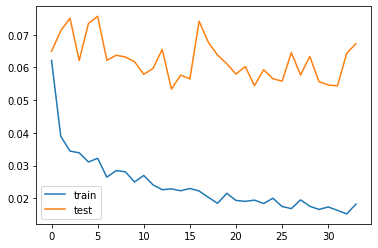

(71, 7)
(71, 7)
(71, 7)
score_train: [13.149] 13.9, 13.4, 14.5, 12.8, 14.3, 11.8, 10.8
(15, 1, 35)
score_test: [30.348] 21.8, 43.3, 36.8, 45.4, 19.2, 10.4, 14.4

RMSE test:  30.3478334025576 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0820
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0872
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0791
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0721
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.0764
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0612
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.0646
Epoch 8/1000
71/71 [=====================

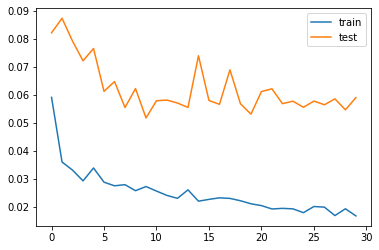

(71, 7)
(71, 7)
(71, 7)
score_train: [13.722] 14.9, 13.9, 14.4, 13.0, 13.0, 14.5, 12.2
(15, 1, 35)
score_test: [28.401] 16.9, 37.0, 33.9, 48.2, 12.6, 16.8, 9.1

RMSE test:  28.401201606425676 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 6ms/step - loss: 0.0649 - val_loss: 0.0522
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0415 - val_loss: 0.0753
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0719
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0741
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0652
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0571
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0813
Epoch 8/1000
71/71 [====================

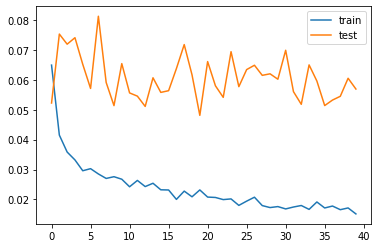

(71, 7)
(71, 7)
(71, 7)
score_train: [13.132] 14.4, 13.9, 13.0, 13.6, 12.6, 12.4, 12.0
(15, 1, 35)
score_test: [27.915] 20.7, 36.4, 38.9, 39.2, 11.1, 16.2, 16.3

RMSE test:  27.91489703478691 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0889
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0383 - val_loss: 0.0847
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0370 - val_loss: 0.0779
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0339 - val_loss: 0.0934
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0882
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.0674
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0690
Epoch 8/1000
71/71 [====================

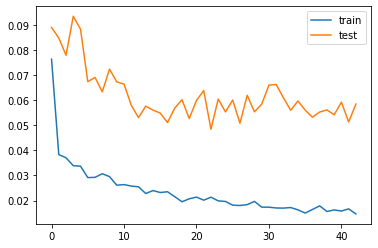

(71, 7)
(71, 7)
(71, 7)
score_train: [12.267] 13.0, 12.8, 13.2, 12.4, 12.1, 11.3, 10.7
(15, 1, 35)
score_test: [28.281] 25.7, 33.2, 37.9, 40.8, 10.7, 20.1, 14.7

RMSE test:  28.281275428896166 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0739 - val_loss: 0.0820
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0389 - val_loss: 0.0783
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0369 - val_loss: 0.0976
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0968
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0787
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.0785
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0743
Epoch 8/1000
71/71 [===================

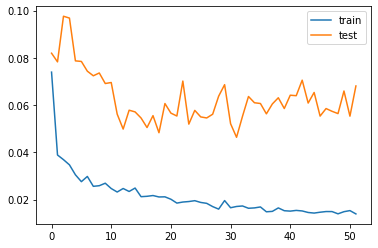

(71, 7)
(71, 7)
(71, 7)
score_train: [12.689] 12.3, 11.8, 13.8, 13.5, 14.6, 11.1, 11.3
(15, 1, 35)
score_test: [30.531] 30.1, 29.2, 20.3, 51.5, 17.8, 31.7, 19.4

RMSE test:  30.53061330174155 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0907 - val_loss: 0.0679
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0394 - val_loss: 0.0762
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0648
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0739
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0633
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0650
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0648
Epoch 8/1000
71/71 [====================

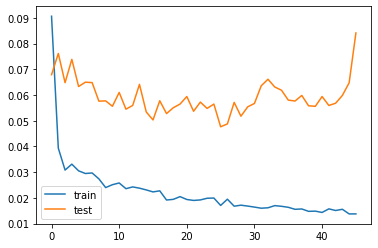

(71, 7)
(71, 7)
(71, 7)
score_train: [13.476] 13.6, 13.4, 14.3, 14.3, 14.1, 11.5, 12.9
(15, 1, 35)
score_test: [33.942] 32.6, 39.7, 24.6, 57.1, 23.3, 27.8, 15.9

RMSE test:  33.9424844900596 

8  	8     	23.7238	3.55271e-15	23.7238	23.7238

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0913
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0384 - val_loss: 0.1023
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.1076
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0843
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0981
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0800
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0

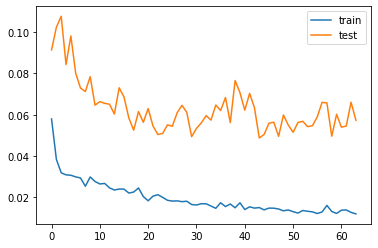

(71, 7)
(71, 7)
(71, 7)
score_train: [11.028] 12.0, 11.6, 13.0, 10.2, 10.9, 9.4, 9.6
(15, 1, 35)
score_test: [28.002] 25.6, 33.3, 35.1, 43.1, 15.9, 16.2, 10.7

RMSE test:  28.00169164776078 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0689 - val_loss: 0.0833
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0427 - val_loss: 0.0926
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0825
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0362 - val_loss: 0.0878
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0719
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0669
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0700
Epoch 8/1000
71/71 [======================

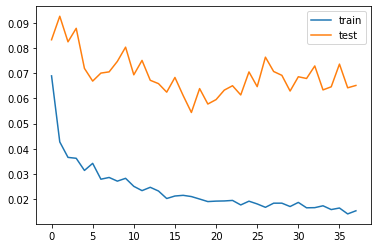

(71, 7)
(71, 7)
(71, 7)
score_train: [12.503] 13.6, 13.0, 13.9, 12.0, 12.1, 11.2, 11.4
(15, 1, 35)
score_test: [29.859] 36.8, 30.2, 31.2, 47.1, 20.1, 11.9, 15.2

RMSE test:  29.85921138432133 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0610
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0409 - val_loss: 0.0676
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0772
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0753
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0808
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0335 - val_loss: 0.0641
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0685
Epoch 8/1000
71/71 [====================

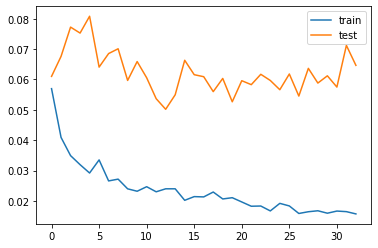

(71, 7)
(71, 7)
(71, 7)
score_train: [12.986] 13.2, 13.5, 14.1, 12.1, 12.7, 12.6, 12.6
(15, 1, 35)
score_test: [29.748] 27.9, 41.9, 29.9, 43.3, 7.9, 23.3, 17.0

RMSE test:  29.747966927642647 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0717
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0407 - val_loss: 0.0914
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0712
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0872
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0662
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0601
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0661
Epoch 8/1000
71/71 [====================

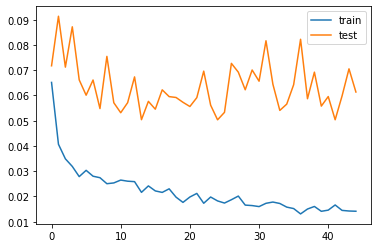

(71, 7)
(71, 7)
(71, 7)
score_train: [12.021] 12.7, 12.6, 13.1, 11.8, 11.7, 11.0, 11.1
(15, 1, 35)
score_test: [28.982] 22.8, 26.3, 27.0, 52.1, 22.7, 16.3, 21.0

RMSE test:  28.98154397962964 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0782 - val_loss: 0.0789
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0436 - val_loss: 0.0879
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0880
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0336 - val_loss: 0.0866
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0769
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0727
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.0632
Epoch 8/1000
71/71 [====================

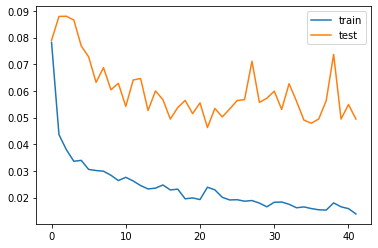

(71, 7)
(71, 7)
(71, 7)
score_train: [12.019] 12.8, 12.5, 13.3, 12.0, 11.4, 11.3, 10.6
(15, 1, 35)
score_test: [26.017] 20.2, 25.9, 31.1, 45.8, 16.3, 16.3, 7.9

RMSE test:  26.016761845925014 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0666 - val_loss: 0.0851
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0420 - val_loss: 0.0877
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0847
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0808
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0768
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0685
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0844
Epoch 8/1000
71/71 [====================

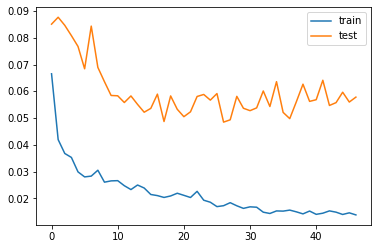

(71, 7)
(71, 7)
(71, 7)
score_train: [12.090] 12.5, 12.5, 12.4, 12.0, 11.6, 11.3, 12.3
(15, 1, 35)
score_test: [28.146] 24.7, 39.8, 32.9, 39.6, 14.8, 19.4, 10.0

RMSE test:  28.146279833790604 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0734
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0394 - val_loss: 0.0686
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0715
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0677
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0732
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0616
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0525
Epoch 8/1000
71/71 [===================

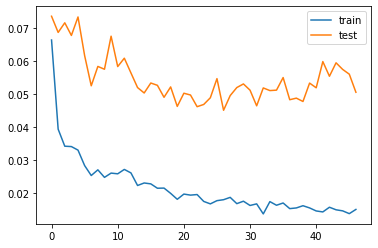

(71, 7)
(71, 7)
(71, 7)
score_train: [12.232] 13.1, 12.8, 13.6, 11.5, 12.0, 11.3, 11.1
(15, 1, 35)
score_test: [26.298] 22.6, 34.8, 32.6, 38.9, 11.5, 15.3, 13.2

RMSE test:  26.298226046181988 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0690 - val_loss: 0.0758
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0404 - val_loss: 0.0755
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0373 - val_loss: 0.0889
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0771
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.0629
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0808
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0736
Epoch 8/1000
71/71 [===================

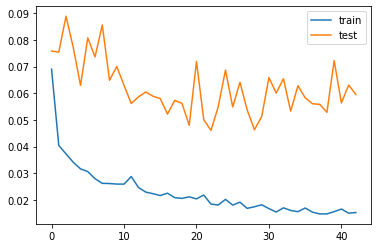

(71, 7)
(71, 7)
(71, 7)
score_train: [12.372] 13.1, 13.0, 13.2, 13.3, 11.7, 10.5, 11.5
(15, 1, 35)
score_test: [28.549] 30.0, 29.0, 31.5, 42.6, 15.0, 22.5, 20.6

RMSE test:  28.54879868845424 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0728
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0390 - val_loss: 0.0826
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0361 - val_loss: 0.0857
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0805
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0770
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.0768
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0660
Epoch 8/1000
71/71 [====================

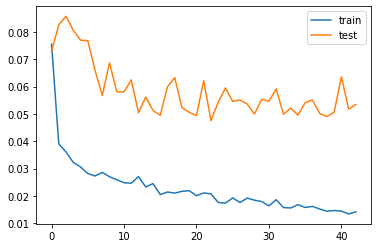

(71, 7)
(71, 7)
(71, 7)
score_train: [12.022] 13.1, 12.0, 13.1, 11.7, 12.5, 10.3, 11.2
(15, 1, 35)
score_test: [27.046] 26.1, 29.9, 38.6, 40.7, 6.6, 18.0, 5.9

RMSE test:  27.04608484031814 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0857
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0413 - val_loss: 0.0829
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0765
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0342 - val_loss: 0.0761
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0796
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0664
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.0712
Epoch 8/1000
71/71 [======================

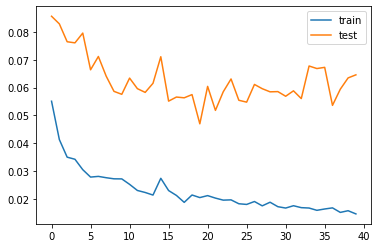

(71, 7)
(71, 7)
(71, 7)
score_train: [12.212] 13.0, 13.0, 12.7, 12.7, 11.4, 10.6, 11.9
(15, 1, 35)
score_test: [29.730] 36.2, 28.8, 38.7, 41.4, 16.2, 14.5, 19.1

RMSE test:  29.730184578870926 

9  	10    	23.7238	3.55271e-15	23.7238	23.7238

Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0590
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0431 - val_loss: 0.0612
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0360 - val_loss: 0.0682
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0732
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0595
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.0592
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss:

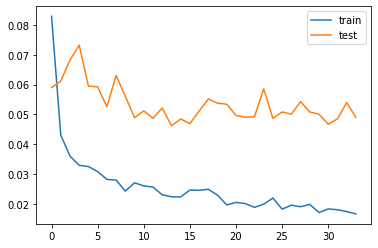

(71, 7)
(71, 7)
(71, 7)
score_train: [13.379] 13.5, 13.5, 14.0, 13.6, 11.8, 13.2, 14.0
(15, 1, 35)
score_test: [25.902] 26.3, 28.9, 32.2, 38.6, 12.1, 15.7, 15.7

RMSE test:  25.901852501876252 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0741
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0420 - val_loss: 0.0965
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0358 - val_loss: 0.0804
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0790
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0839
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0706
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.0899
Epoch 8/1000
71/71 [===================

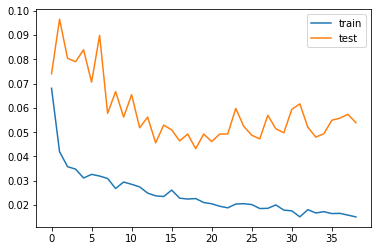

(71, 7)
(71, 7)
(71, 7)
score_train: [12.622] 14.2, 12.9, 13.3, 12.5, 12.0, 11.8, 11.3
(15, 1, 35)
score_test: [27.161] 19.0, 39.7, 29.4, 37.5, 9.9, 18.9, 22.4

RMSE test:  27.161413239842194 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0593
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0448 - val_loss: 0.0530
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0337 - val_loss: 0.0508
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0570
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0340 - val_loss: 0.0493
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0607
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.0444
Epoch 8/1000
71/71 [====================

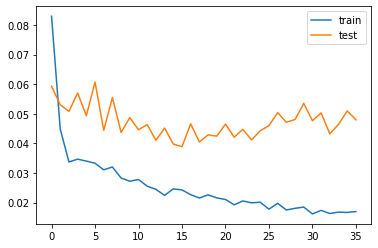

(71, 7)
(71, 7)
(71, 7)
score_train: [12.864] 14.4, 13.1, 13.4, 13.1, 12.7, 11.5, 11.7
(15, 1, 35)
score_test: [25.627] 22.2, 32.4, 32.3, 36.9, 16.5, 16.7, 9.9

RMSE test:  25.626643540829217 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 1s 7ms/step - loss: 0.0667 - val_loss: 0.0759
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0402 - val_loss: 0.0860
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0384 - val_loss: 0.0826
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0761
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0778
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0748
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0665
Epoch 8/1000
71/71 [====================

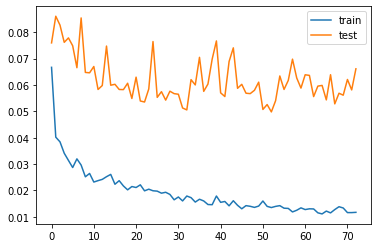

(71, 7)
(71, 7)
(71, 7)
score_train: [11.517] 12.4, 11.1, 12.2, 10.8, 11.5, 12.5, 9.8
(15, 1, 35)
score_test: [30.079] 28.5, 38.1, 31.3, 40.6, 19.6, 28.2, 16.3

RMSE test:  30.079404568594445 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0713 - val_loss: 0.0857
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0471 - val_loss: 0.0799
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0414 - val_loss: 0.0746
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0323 - val_loss: 0.0820
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0725
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.0710
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0735
Epoch 8/1000
71/71 [====================

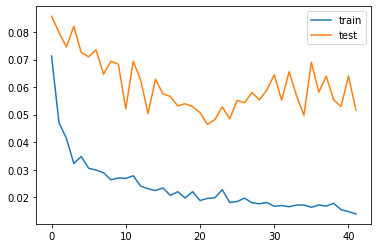

(71, 7)
(71, 7)
(71, 7)
score_train: [12.932] 12.9, 15.2, 13.2, 12.3, 13.3, 11.4, 11.9
(15, 1, 35)
score_test: [26.589] 17.2, 36.1, 31.5, 40.0, 12.0, 17.3, 17.8

RMSE test:  26.589486029552813 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0755 - val_loss: 0.0897
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0397 - val_loss: 0.1006
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.1083
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0324 - val_loss: 0.0792
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.0889
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.0665
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0720
Epoch 8/1000
71/71 [===================

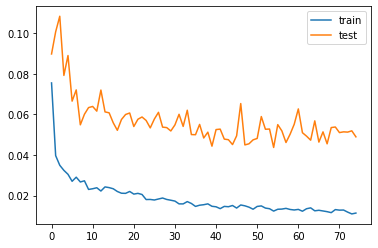

(71, 7)
(71, 7)
(71, 7)
score_train: [10.492] 11.5, 11.0, 11.2, 10.3, 9.6, 10.2, 9.3
(15, 1, 35)
score_test: [25.876] 26.1, 28.0, 33.5, 36.0, 15.2, 10.9, 21.3

RMSE test:  25.876204807687408 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0586 - val_loss: 0.0683
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0639
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0768
Epoch 4/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0596
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0571
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0817
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0683
Epoch 8/1000
71/71 [=====================

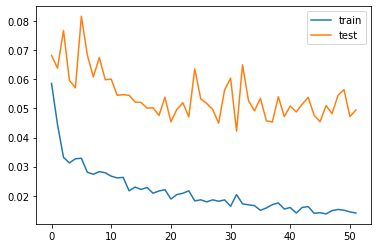

(71, 7)
(71, 7)
(71, 7)
score_train: [11.718] 12.2, 12.6, 12.0, 11.7, 11.9, 11.0, 10.5
(15, 1, 35)
score_test: [26.025] 21.6, 30.3, 31.6, 41.8, 19.3, 9.3, 12.2

RMSE test:  26.025491555064566 


Units CNN1:  127 Units CNN2:  127 ,Sequence size:  7
(71, 1, 35)
Epoch 1/1000
71/71 [==============================] - 0s 3ms/step - loss: 0.0683 - val_loss: 0.0722
Epoch 2/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0384 - val_loss: 0.0704
Epoch 3/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0350 - val_loss: 0.0748
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0756
Epoch 5/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0326 - val_loss: 0.0762
Epoch 6/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0634
Epoch 7/1000
71/71 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0594
Epoch 8/1000
71/71 [====================

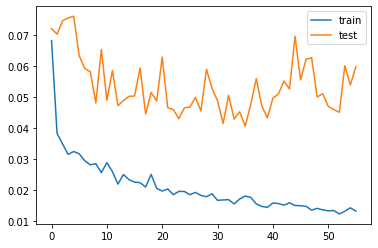

(71, 7)
(71, 7)
(71, 7)
score_train: [11.301] 11.9, 12.4, 11.7, 11.4, 10.6, 10.1, 10.7
(15, 1, 35)
score_test: [28.651] 27.4, 27.6, 25.2, 48.1, 15.5, 26.4, 18.7

RMSE test:  28.650821687932762 

10 	8     	23.7238	3.55271e-15	23.7238	23.7238


In [76]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =14 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [77]:
print('Best score :', best_score)

Best score : 23.723832170391304


In [78]:
model=model_name
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 1, 127)            9017      
_________________________________________________________________
flatten_43 (Flatten)         (None, 127)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 127)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 7)                 896       
Total params: 9,913
Trainable params: 9,913
Non-trainable params: 0
_________________________________________________________________


In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14]])
yhat.shape 

(3, 7)

In [80]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [81]:
#yhat

In [82]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [83]:
days

DatetimeIndex(['2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [84]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:21]
test_res['real']=y_test_true.flatten()[0:21]
test_res.set_index(days,inplace=True)

In [85]:
test_res

,Prediction,real
timestamp,,
2020-05-25,61.149544,27.0
2020-05-26,64.049644,99.0
2020-05-27,50.727615,45.0
2020-05-28,33.017941,24.0
2020-05-29,59.758930,42.0
2020-05-30,52.877625,71.0
2020-05-31,56.494957,66.0
2020-06-01,51.409325,27.0
2020-06-02,40.651100,26.0


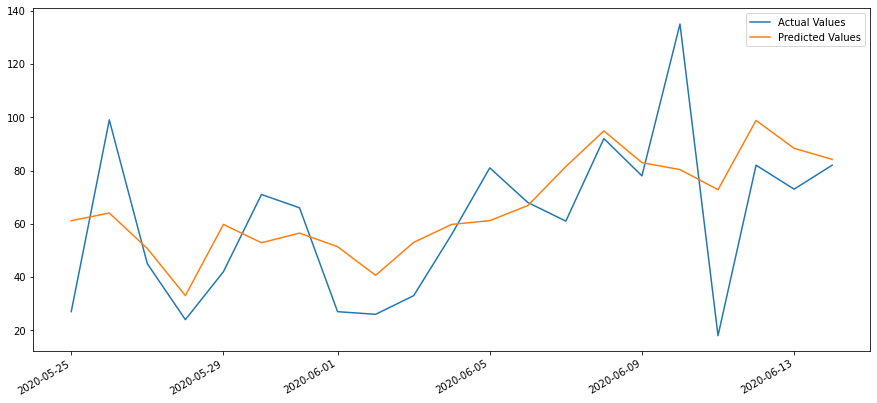

In [86]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [87]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 562.82
RMSE: 23.72
MAE: 18.34
R Squared: 0.34
Max Error: 54.8


In [88]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(71, 7)

In [89]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(71, 7)

In [90]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [91]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [92]:
y_train_pred[0]

array([20.968102, 19.61622 , 21.141726, 20.679405, 22.79073 , 23.59962 ,
       25.013376], dtype=float32)

In [93]:
#For plot 
#filter_indices = [0,6,13,20,27,34,41,48,55,62,69,76,83,90,97,104]
filter_indices = [0,6,13,20,27,34,41,48,55,62,69]
y_train_pred = y_train_pred [filter_indices ]

In [94]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [95]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(71, 1, 35)

In [96]:
date_train.head(7)

22928   2020-03-02
22929   2020-03-03
22930   2020-03-04
22931   2020-03-05
22932   2020-03-06
22933   2020-03-07
22934   2020-03-08
Name: date, dtype: datetime64[ns]

In [97]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

77

In [98]:
date_train = date_train.values.flatten()

In [99]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [100]:
Y_train_pred.shape

(77,)

In [101]:
Y_train_real.shape

(77,)

In [102]:
date_train.shape

(84,)

In [103]:
date_train[nb_seq:].shape

(77,)

In [104]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

0

In [105]:
Y_train_real[:-suite_size].shape

(0,)

In [106]:
date_train[nb_seq:].shape

(77,)

In [107]:
Y_train_pred[:-suite_size].shape

(0,)

In [108]:
Y_train_real[:-suite_size].shape

(0,)

In [109]:
date_trainX = date_train[nb_seq:]

In [110]:
date_trainX[0:Y_train_pred.shape[0]].shape

(77,)

In [111]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [112]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [113]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [114]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-09,20.914591,20.968102
2020-03-10,20.914591,19.616220
2020-03-11,20.914591,21.141726
2020-03-12,19.249111,20.679405
2020-03-13,18.416370,22.790730
2020-03-14,18.416370,23.599621
2020-03-15,22.580070,25.013376
2020-03-16,22.580070,23.190258
2020-03-17,22.163700,21.261883


In [115]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-05-15,57.138786,64.812515
2020-05-16,57.555161,63.406750
2020-05-17,36.736652,64.660614
2020-05-18,55.056934,55.831299
2020-05-19,71.711739,59.962212
2020-05-20,52.142349,55.113422
2020-05-21,47.562275,54.925934
2020-05-22,63.800713,56.538090
2020-05-23,50.476868,50.728989


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

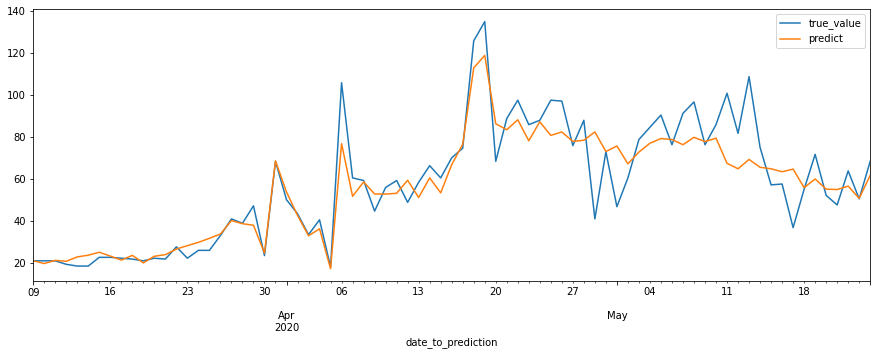

In [116]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [117]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 133.08
RMSE 11.54
MAE 8.04
R2 0.83
maxError 41.49
